# 03 - Feature Engineering: CICIDS2017 Dataset

This notebook performs feature engineering, selection, and dimensionality reduction.

## Objectives:
1. Load preprocessed data
2. Analyze feature correlations
3. Feature selection using various methods
4. Dimensionality reduction (PCA)
5. Create final feature set for training
6. Save engineered features

## 1. Setup and Imports

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import yaml
import joblib
import os

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load Preprocessed Data

In [4]:
import os
import joblib
from src.data_processing import DataProcessor

# Root folder of your project
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Load processor
processor = DataProcessor(config_path=os.path.join(root_path, "config/config.yaml"))

# Fix processed path to be absolute
processor.config['paths']['data_processed'] = os.path.join(root_path, "data/processed")

# Load processed data
X_train, X_val, X_test, y_train, y_val, y_test = processor.load_processed_data()

# Load feature names
feature_names = joblib.load(os.path.join(root_path, "data/processed/feature_names.pkl"))

print("✓ Data loaded successfully")
print(f"  Training samples: {X_train.shape}")
print(f"  Validation samples: {X_val.shape}")
print(f"  Test samples: {X_test.shape}")
print(f"  Number of features: {len(feature_names)}")


INFO:src.data_processing:Configuration loaded from c:\Users\ghada\intrusion-detection-system\config/config.yaml
INFO:src.data_processing:Loading processed data...
INFO:src.data_processing:Data loaded successfully


✓ Data loaded successfully
  Training samples: (2935076, 78)
  Validation samples: (252237, 78)
  Test samples: (504473, 78)
  Number of features: 78


## 3. Feature Correlation Analysis

In [5]:
print("\n=== Feature Correlation Analysis ===")

X_train_df = pd.DataFrame(X_train, columns=feature_names)

correlation_matrix = X_train_df.corr()

print(f"\n✓ Correlation matrix computed: {correlation_matrix.shape}")


=== Feature Correlation Analysis ===

✓ Correlation matrix computed: (78, 78)


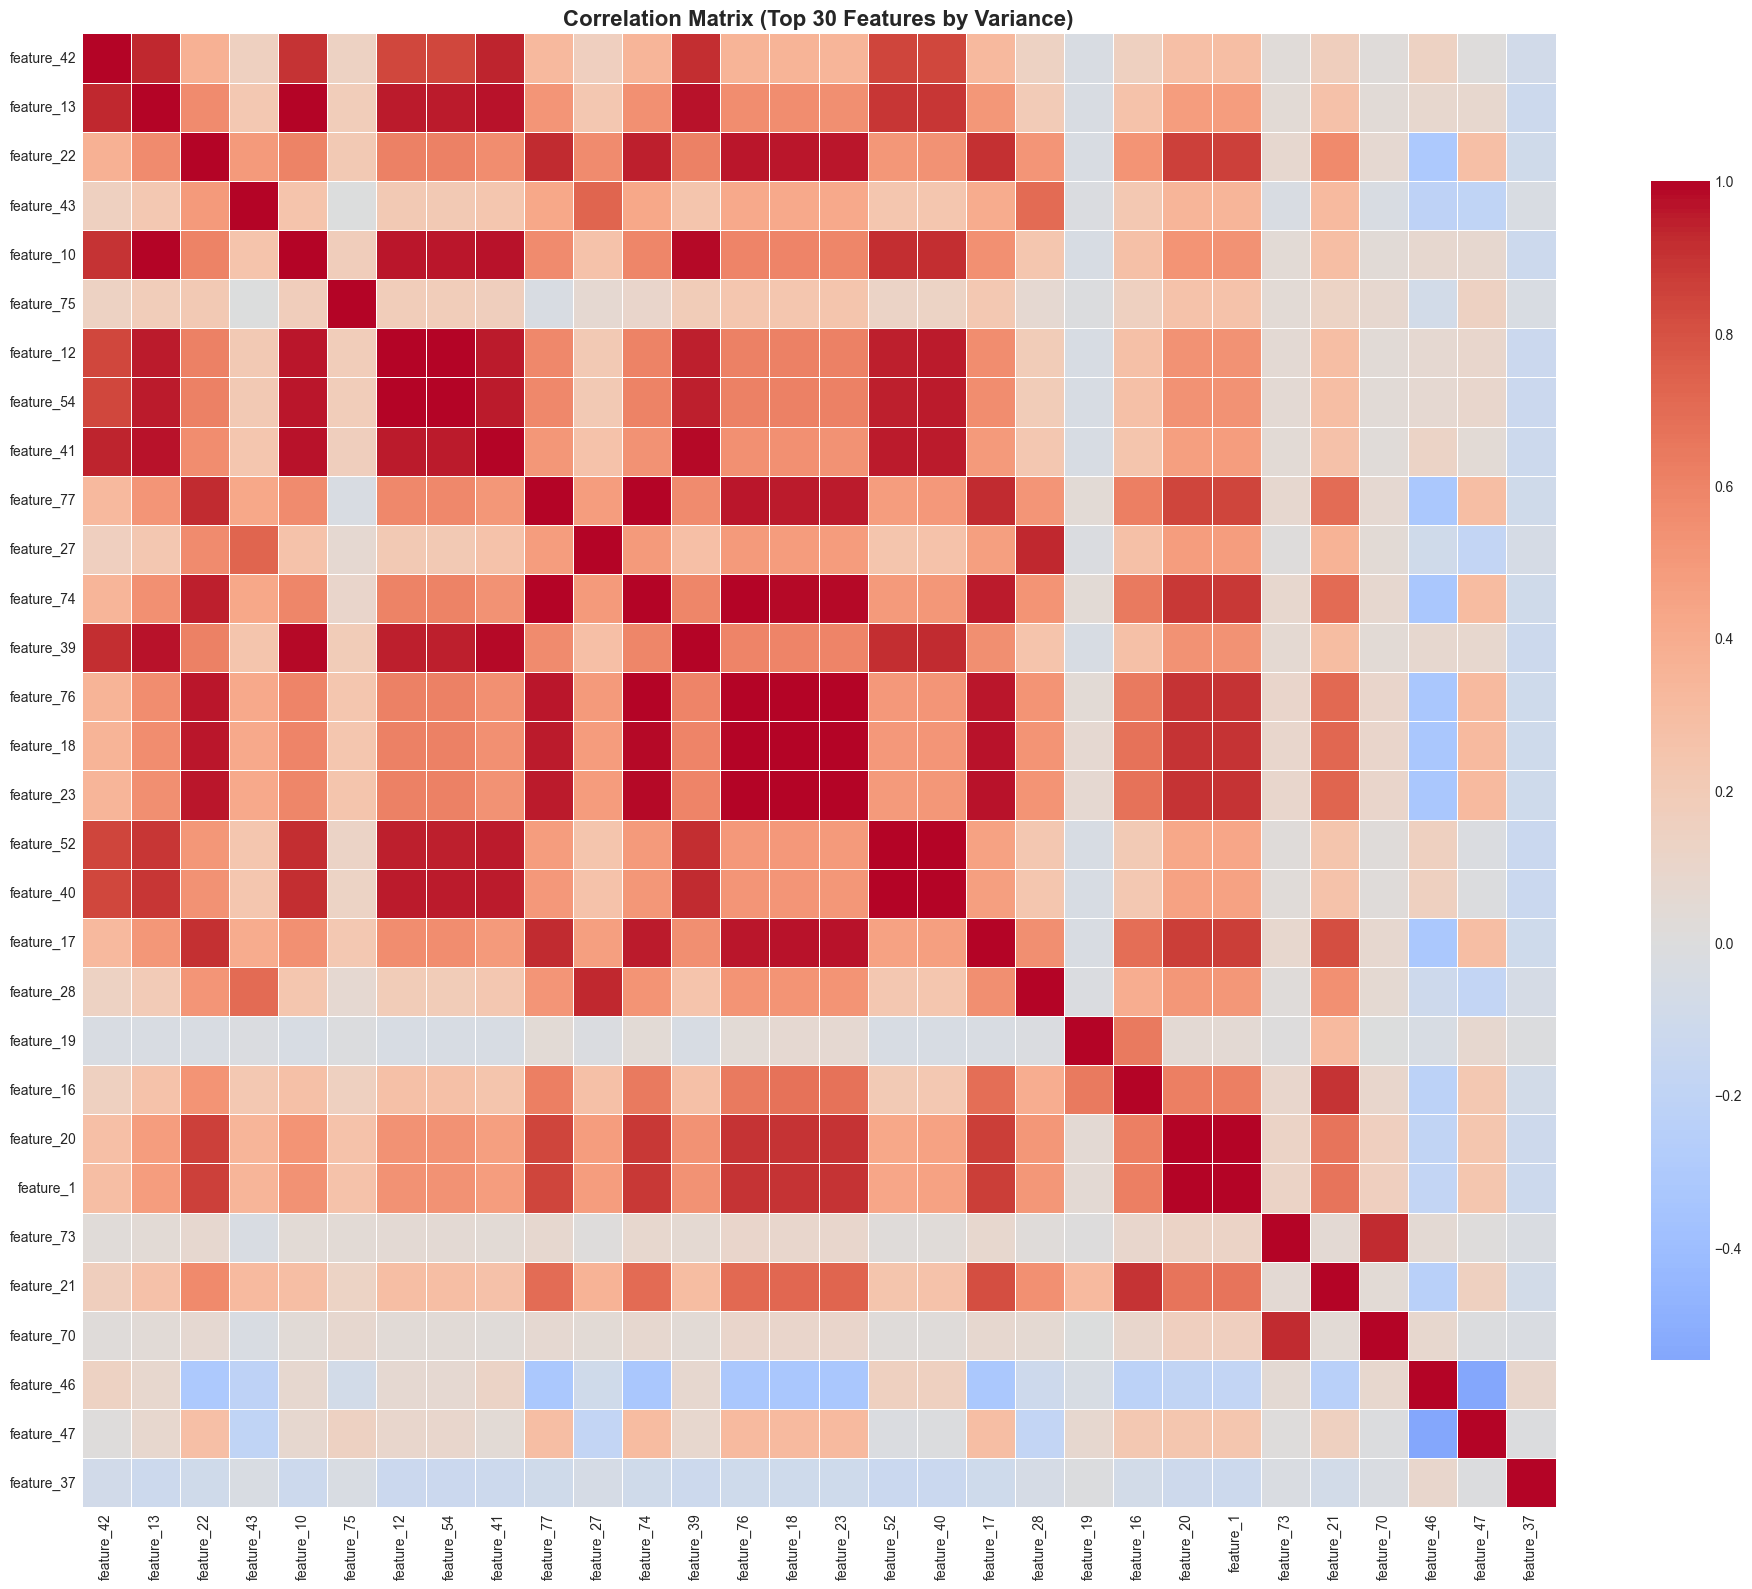

In [6]:
plt.figure(figsize=(20, 16))

top_features = X_train_df.var().nlargest(30).index
corr_subset = correlation_matrix.loc[top_features, top_features]

sns.heatmap(corr_subset, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (Top 30 Features by Variance)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [7]:
print("\n=== Finding Highly Correlated Feature Pairs ===")

threshold = 0.95
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs (>{threshold}):")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:15]:
        print(f"  {feat1[:35]:35s} <-> {feat2[:35]:35s} : {corr:.3f}")
    
    features_to_drop = list(set([pair[1] for pair in high_corr_pairs]))
    print(f"\n  → Recommend removing {len(features_to_drop)} correlated features")
else:
    features_to_drop = []
    print("✓ No highly correlated features found")


=== Finding Highly Correlated Feature Pairs ===

Found 60 highly correlated feature pairs (>0.95):
  feature_12                          <-> feature_54                          : 1.000
  feature_2                           <-> feature_62                          : 1.000
  feature_3                           <-> feature_64                          : 1.000
  feature_8                           <-> feature_53                          : 1.000
  feature_30                          <-> feature_44                          : 1.000
  feature_32                          <-> feature_49                          : 1.000
  feature_34                          <-> feature_55                          : 1.000
  feature_5                           <-> feature_65                          : 1.000
  feature_4                           <-> feature_63                          : 1.000
  feature_18                          <-> feature_23                          : 0.999
  feature_1                           <-

## 4. Feature Selection - Method 1: Statistical Tests

In [8]:
print("\n=== Method 1: Statistical Feature Selection (ANOVA F-test) ===")

k_best = min(50, len(feature_names))
selector = SelectKBest(score_func=f_classif, k=k_best)
selector.fit(X_train, y_train)

scores = pd.DataFrame({
    'Feature': feature_names,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

print(f"\n✓ Selected top {k_best} features using ANOVA F-test")
print(f"\nTop 15 features by F-score:")
print(scores.head(15))

statistical_features = scores.head(k_best)['Feature'].tolist()


=== Method 1: Statistical Feature Selection (ANOVA F-test) ===

✓ Selected top 50 features using ANOVA F-test

Top 15 features by F-score:
       Feature         Score
12  feature_12  1.233633e+06
54  feature_54  1.233633e+06
13  feature_13  1.185167e+06
10  feature_10  1.179510e+06
41  feature_41  1.116159e+06
39  feature_39  1.065877e+06
40  feature_40  9.855786e+05
52  feature_52  9.605491e+05
42  feature_42  8.033457e+05
22  feature_22  7.612131e+05
76  feature_76  7.150580e+05
18  feature_18  7.106208e+05
23  feature_23  7.093824e+05
74  feature_74  6.874514e+05
38  feature_38  6.632765e+05


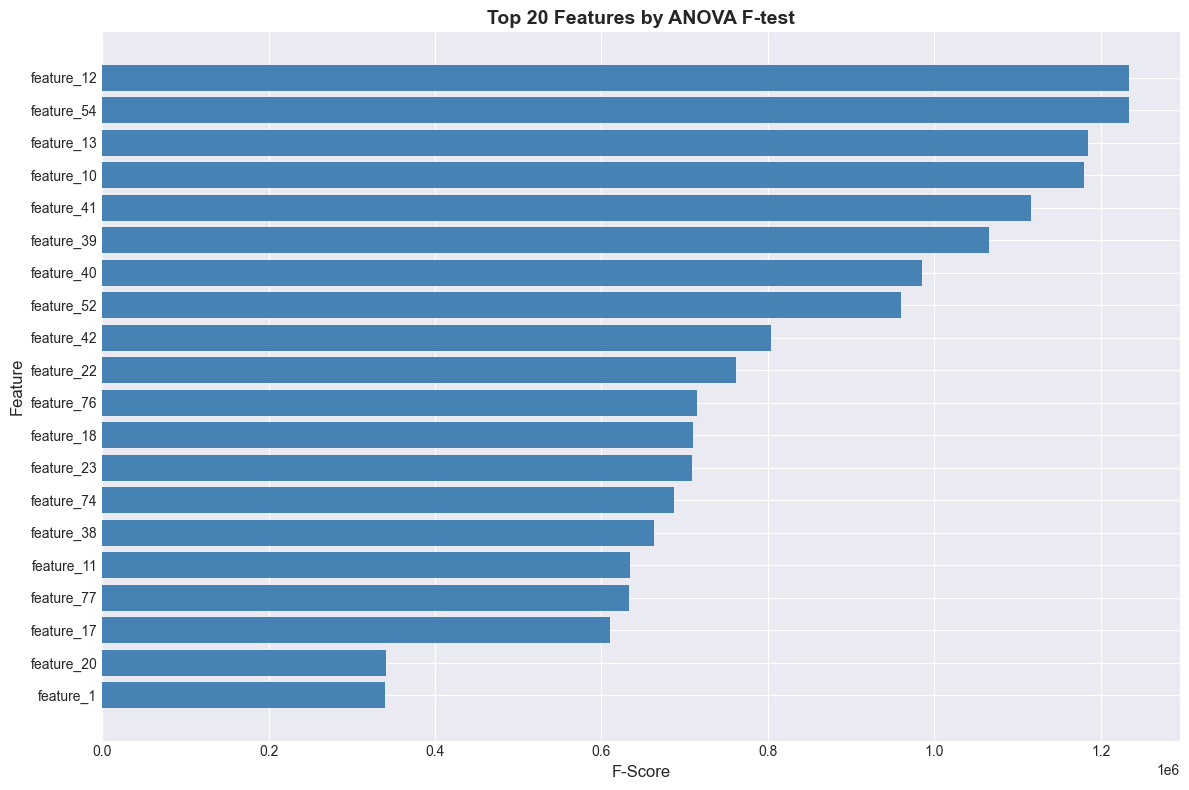

In [9]:
plt.figure(figsize=(12, 8))
top_20 = scores.head(20)
plt.barh(range(len(top_20)), top_20['Score'], color='steelblue')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('F-Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features by ANOVA F-test', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5. Feature Selection - Method 2: Tree-based Importance

In [10]:
print("\n=== Method 2: Tree-based Feature Importance ===")

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
print("Training Random Forest for feature importance...")
rf.fit(X_train, y_train)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n✓ Feature importance calculated")
print(f"\nTop 15 features by importance:")
print(importance_df.head(15))

tree_based_features = importance_df.head(50)['Feature'].tolist()


=== Method 2: Tree-based Feature Importance ===
Training Random Forest for feature importance...

✓ Feature importance calculated

Top 15 features by importance:
       Feature  Importance
39  feature_39    0.083191
41  feature_41    0.078798
52  feature_52    0.069650
42  feature_42    0.059020
54  feature_54    0.058674
10  feature_10    0.042876
13  feature_13    0.039299
0    feature_0    0.036016
6    feature_6    0.028708
5    feature_5    0.027804
40  feature_40    0.026392
63  feature_63    0.026018
8    feature_8    0.025983
67  feature_67    0.023503
66  feature_66    0.022144


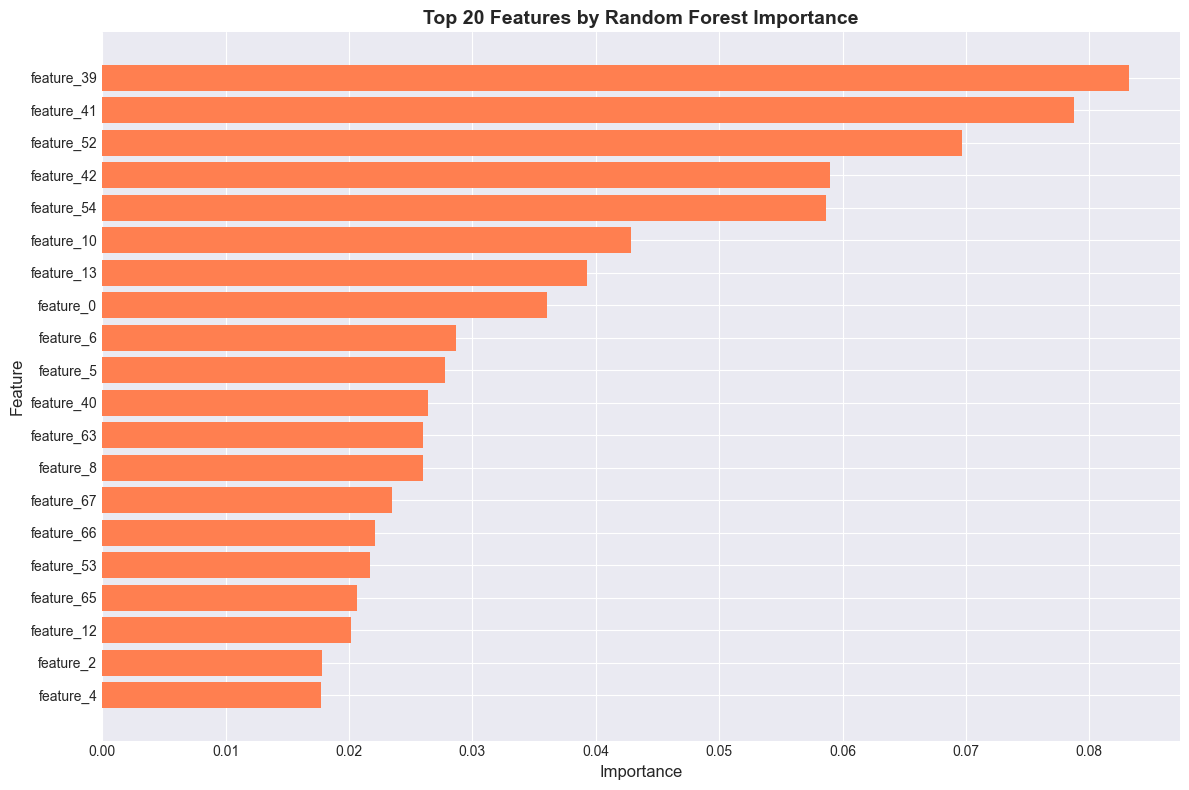

In [11]:
plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['Importance'], color='coral')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features by Random Forest Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Feature Selection - Method 3: Mutual Information

In [12]:
print("\n=== Method 3: Mutual Information ===")

print("Computing mutual information scores...")
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

mi_df = pd.DataFrame({
    'Feature': feature_names,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print(f"\n✓ Mutual information calculated")
print(f"\nTop 15 features by MI:")
print(mi_df.head(15))

mi_features = mi_df.head(50)['Feature'].tolist()


=== Method 3: Mutual Information ===
Computing mutual information scores...

✓ Mutual information calculated

Top 15 features by MI:
       Feature  MI_Score
0    feature_0  0.574508
52  feature_52  0.547654
41  feature_41  0.523163
42  feature_42  0.520287
40  feature_40  0.503313
4    feature_4  0.480108
63  feature_63  0.479868
54  feature_54  0.476809
12  feature_12  0.476290
39  feature_39  0.475841
65  feature_65  0.470094
5    feature_5  0.469939
66  feature_66  0.469920
10  feature_10  0.445851
6    feature_6  0.445833


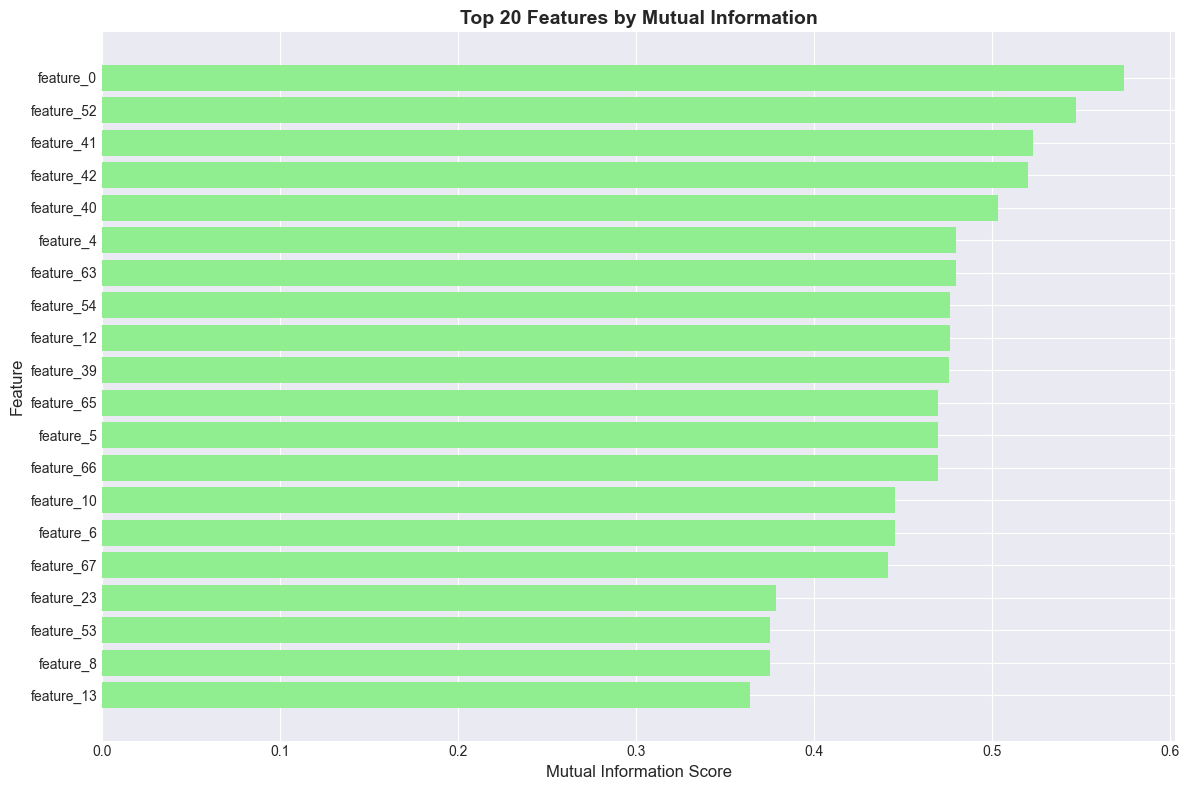

In [13]:
plt.figure(figsize=(12, 8))
top_20 = mi_df.head(20)
plt.barh(range(len(top_20)), top_20['MI_Score'], color='lightgreen')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features by Mutual Information', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Combine Feature Selection Methods

In [14]:
print("\n=== Combining Feature Selection Methods ===")

from collections import Counter

all_selected_features = statistical_features + tree_based_features + mi_features
feature_votes = Counter(all_selected_features)

print(f"\nFeature selection summary:")
print(f"  Statistical (ANOVA): {len(statistical_features)} features")
print(f"  Tree-based: {len(tree_based_features)} features")
print(f"  Mutual Information: {len(mi_features)} features")

consensus_threshold = 2
selected_features = [feat for feat, votes in feature_votes.items() if votes >= consensus_threshold]

selected_features = [f for f in selected_features if f not in features_to_drop]

print(f"\n✓ Consensus features (appearing in {consensus_threshold}+ methods): {len(selected_features)}")
print(f"✓ After removing correlated features: {len(selected_features)}")

print(f"\nFeature vote distribution:")
vote_dist = Counter(feature_votes.values())
for votes, count in sorted(vote_dist.items(), reverse=True):
    print(f"  {votes} votes: {count} features")


=== Combining Feature Selection Methods ===

Feature selection summary:
  Statistical (ANOVA): 50 features
  Tree-based: 50 features
  Mutual Information: 50 features

✓ Consensus features (appearing in 2+ methods): 30
✓ After removing correlated features: 30

Feature vote distribution:
  3 votes: 31 features
  2 votes: 22 features
  1 votes: 13 features


## 8. Apply Feature Selection

In [15]:
print("\n=== Applying Feature Selection ===")

selected_indices = [feature_names.index(f) for f in selected_features]

X_train_selected = X_train[:, selected_indices]
X_val_selected = X_val[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

print(f"\n✓ Feature selection applied")
print(f"  Original features: {X_train.shape[1]}")
print(f"  Selected features: {X_train_selected.shape[1]}")
print(f"  Reduction: {(1 - X_train_selected.shape[1]/X_train.shape[1])*100:.1f}%")

print(f"\nSelected features:")
for i, feat in enumerate(selected_features[:20], 1):
    print(f"  {i:2d}. {feat}")
if len(selected_features) > 20:
    print(f"  ... and {len(selected_features) - 20} more")


=== Applying Feature Selection ===

✓ Feature selection applied
  Original features: 78
  Selected features: 30
  Reduction: 61.5%

Selected features:
   1. feature_10
   2. feature_42
   3. feature_38
   4. feature_11
   5. feature_17
   6. feature_1
   7. feature_16
   8. feature_0
   9. feature_21
  10. feature_48
  11. feature_7
  12. feature_46
  13. feature_27
  14. feature_67
  15. feature_28
  16. feature_47
  17. feature_8
  18. feature_15
  19. feature_6
  20. feature_29
  ... and 10 more


## 9. Dimensionality Reduction with PCA (Optional)

In [16]:
print("\n=== Dimensionality Reduction with PCA ===")

apply_pca = True

if apply_pca:
    n_components = min(30, X_train_selected.shape[1])
    
    print(f"Applying PCA with {n_components} components...")
    pca = PCA(n_components=n_components, random_state=42)
    
    X_train_pca = pca.fit_transform(X_train_selected)
    X_val_pca = pca.transform(X_val_selected)
    X_test_pca = pca.transform(X_test_selected)
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    print(f"\n✓ PCA applied")
    print(f"  Explained variance by {n_components} components: {cumulative_variance[-1]*100:.2f}%")
    print(f"  Variance per component (top 10):")
    for i in range(min(10, n_components)):
        print(f"    PC{i+1}: {explained_variance[i]*100:.2f}%")
else:
    print("Skipping PCA")
    X_train_pca = X_train_selected
    X_val_pca = X_val_selected
    X_test_pca = X_test_selected
    pca = None


=== Dimensionality Reduction with PCA ===
Applying PCA with 30 components...

✓ PCA applied
  Explained variance by 30 components: 100.00%
  Variance per component (top 10):
    PC1: 25.69%
    PC2: 13.20%
    PC3: 9.27%
    PC4: 7.05%
    PC5: 5.95%
    PC6: 4.93%
    PC7: 4.33%
    PC8: 4.15%
    PC9: 3.52%
    PC10: 3.14%


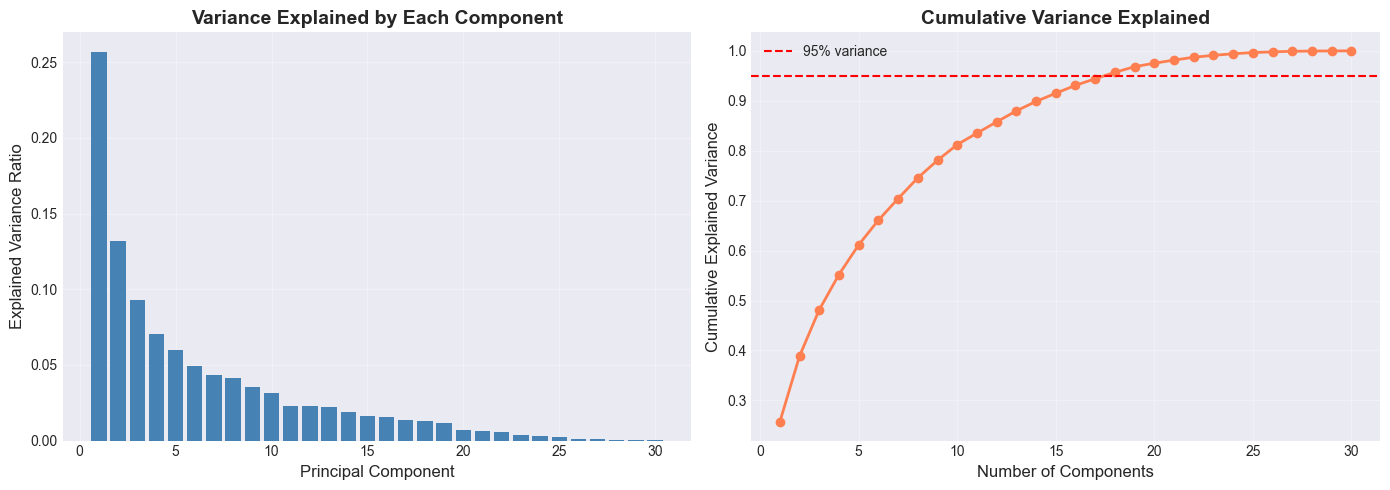

In [18]:
if apply_pca and pca is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].bar(range(1, len(explained_variance)+1), explained_variance, color='steelblue')
    axes[0].set_xlabel('Principal Component', fontsize=12)
    axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
    axes[0].set_title('Variance Explained by Each Component', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 
                 marker='o', color='coral', linewidth=2)
    axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
    axes[1].set_xlabel('Number of Components', fontsize=12)
    axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
    axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 10. Save Engineered Features

In [19]:
print("\n=== Saving Engineered Features ===")

processed_path = '../data/processed'
os.makedirs(processed_path, exist_ok=True)

np.save(os.path.join(processed_path, 'X_train_engineered.npy'), X_train_pca)
np.save(os.path.join(processed_path, 'X_val_engineered.npy'), X_val_pca)
np.save(os.path.join(processed_path, 'X_test_engineered.npy'), X_test_pca)

joblib.dump(selected_features, os.path.join(processed_path, 'selected_features.pkl'))

if pca is not None:
    joblib.dump(pca, os.path.join(processed_path, 'pca_model.pkl'))

feature_engineering_info = {
    'original_features': len(feature_names),
    'selected_features': len(selected_features),
    'pca_applied': apply_pca,
    'n_components': n_components if apply_pca else None,
    'explained_variance': float(cumulative_variance[-1]) if apply_pca else None,
    'final_dimensions': X_train_pca.shape[1],
    'feature_list': selected_features
}

import json
with open(os.path.join(processed_path, 'feature_engineering_info.json'), 'w') as f:
    json.dump(feature_engineering_info, f, indent=2)

print(f"\n✓ All data saved to {processed_path}")


=== Saving Engineered Features ===

✓ All data saved to ../data/processed


In [20]:
print("\nSaved files:")
for file in Path(processed_path).glob('*engineered*'):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  ✓ {file.name} ({size_mb:.2f} MB)")

print(f"  ✓ selected_features.pkl")
if pca is not None:
    print(f"  ✓ pca_model.pkl")
print(f"  ✓ feature_engineering_info.json")


Saved files:
  ✓ X_test_engineered.npy (115.46 MB)
  ✓ X_train_engineered.npy (671.79 MB)
  ✓ X_val_engineered.npy (57.73 MB)
  ✓ selected_features.pkl
  ✓ pca_model.pkl
  ✓ feature_engineering_info.json


## 11. Summary

In [21]:
print("\n" + "="*70)
print("FEATURE ENGINEERING - SUMMARY")
print("="*70)

print(f"\n📊 Feature Selection Results:")
print(f"  Original features: {len(feature_names)}")
print(f"  Features removed (correlation): {len(features_to_drop)}")
print(f"  Features selected: {len(selected_features)}")
print(f"  Reduction ratio: {(1 - len(selected_features)/len(feature_names))*100:.1f}%")

if apply_pca:
    print(f"\n🔬 Dimensionality Reduction (PCA):")
    print(f"  PCA components: {n_components}")
    print(f"  Variance retained: {cumulative_variance[-1]*100:.2f}%")
    print(f"  Final dimensions: {X_train_pca.shape[1]}")

print(f"\n📈 Final Dataset Shapes:")
print(f"  Training: {X_train_pca.shape}")
print(f"  Validation: {X_val_pca.shape}")
print(f"  Test: {X_test_pca.shape}")

print(f"\n✅ Feature engineering complete!")
print(f"\n📝 Next Steps:")
print(f"  1. Run 04_model_training.ipynb to train ML models")
print(f"  2. Experiment with different algorithms")
print(f"  3. Compare model performances")

print("\n" + "="*70)


FEATURE ENGINEERING - SUMMARY

📊 Feature Selection Results:
  Original features: 78
  Features removed (correlation): 27
  Features selected: 30
  Reduction ratio: 61.5%

🔬 Dimensionality Reduction (PCA):
  PCA components: 30
  Variance retained: 100.00%
  Final dimensions: 30

📈 Final Dataset Shapes:
  Training: (2935076, 30)
  Validation: (252237, 30)
  Test: (504473, 30)

✅ Feature engineering complete!

📝 Next Steps:
  1. Run 04_model_training.ipynb to train ML models
  2. Experiment with different algorithms
  3. Compare model performances

